# Problem 10: Full GPT-2 Model Assembly - Interactive Notebook

Explore the complete GPT-2 architecture and understand how all components work together.

In [1]:
import sys
sys.path.append('../09-gpt2-config')

import torch
import matplotlib.pyplot as plt
import numpy as np

# When finished, uncomment the following sentence and import your own solution
from solution import GPT2Model, GPT2Config
# from problem import GPT2Model, GPT2Config

plt.rcParams['figure.figsize'] = (14, 10)
print('Setup complete!')

Setup complete!


## Create GPT-2 Models of Different Sizes

In [2]:
# Create models for different sizes
configs = {
    'Small': GPT2Config.gpt2_small(),
    'Medium': GPT2Config.gpt2_medium(),
    'Large': GPT2Config.gpt2_large(),
    'XL': GPT2Config.gpt2_xl(),
}

# Create a small model for experiments
small_config = GPT2Config.gpt2_small()
model = GPT2Model(small_config)

print(f'Created GPT-2 Small model with {small_config.n_layer} layers')
print(f'Embedding dimension: {small_config.n_embd}')
print(f'Attention heads: {small_config.n_head}')
print(f'FFN inner dimension: {small_config.n_inner}')
print(f'Vocabulary size: {small_config.vocab_size:,}')
print(f'Context length: {small_config.n_positions}')

Created GPT-2 Small model with 12 layers
Embedding dimension: 768
Attention heads: 12
FFN inner dimension: 3072
Vocabulary size: 50,257
Context length: 1024


## Test Forward Pass

In [3]:
# Create sample input
batch_size = 2
seq_len = 20
input_ids = torch.randint(0, small_config.vocab_size, (batch_size, seq_len))

print(f'Input shape: {input_ids.shape}')
print(f'Sample tokens: {input_ids[0, :10].tolist()}')

# Forward pass
model.eval()
with torch.no_grad():
    logits = model(input_ids)

print(f'\nOutput logits shape: {logits.shape}')
print(f'Expected: (batch_size={batch_size}, seq_len={seq_len}, vocab_size={small_config.vocab_size})')

# Get probabilities
probs = torch.softmax(logits, dim=-1)
print(f'\nProbabilities shape: {probs.shape}')
print(f'Probabilities sum to 1: {probs[0, 0].sum():.6f}')

Input shape: torch.Size([2, 20])
Sample tokens: [26562, 18600, 24309, 18471, 29493, 25496, 40893, 20190, 19974, 1031]

Output logits shape: torch.Size([2, 20, 50257])
Expected: (batch_size=2, seq_len=20, vocab_size=50257)

Probabilities shape: torch.Size([2, 20, 50257])
Probabilities sum to 1: 1.000000


## Visualize Model Architecture

Parameter Breakdown:
embeddings               :   39,383,808 ( 31.6%)
transformer_blocks       :   85,054,464 ( 68.3%)
final_ln                 :        1,536 (  0.0%)
lm_head                  :            0 (  0.0%)
total                    :  124,439,808 (100.0%)


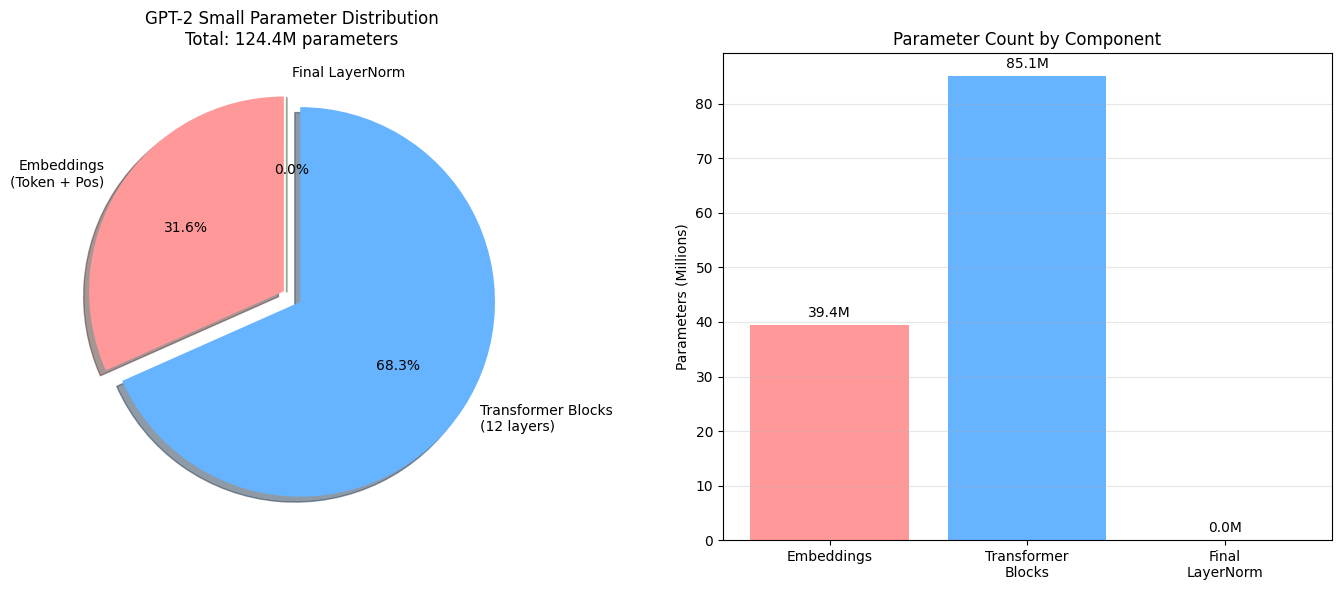


Most parameters are in the transformer blocks!


In [4]:
# Count parameters by component
param_breakdown = model.get_num_params_by_component()

# Print breakdown
print('Parameter Breakdown:')
print('=' * 60)
for component, count in param_breakdown.items():
    if component == 'total':
        print('=' * 60)
    pct = (count / param_breakdown['total'] * 100) if param_breakdown['total'] > 0 else 0
    print(f'{component:25s}: {count:>12,} ({pct:>5.1f}%)')

# Visualize parameter distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
components = ['embeddings', 'transformer_blocks', 'final_ln']
sizes = [param_breakdown[c] for c in components]
labels = ['Embeddings\n(Token + Pos)', 'Transformer Blocks\n(12 layers)', 'Final LayerNorm']
colors = ['#ff9999', '#66b3ff', '#99ff99']
explode = (0.05, 0.05, 0.05)

ax1.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
ax1.set_title(f'GPT-2 Small Parameter Distribution\nTotal: {param_breakdown["total"]/1e6:.1f}M parameters')

# Bar chart
component_names = ['Embeddings', 'Transformer\nBlocks', 'Final\nLayerNorm']
ax2.bar(range(len(components)), [s/1e6 for s in sizes], color=colors)
ax2.set_xticks(range(len(components)))
ax2.set_xticklabels(component_names)
ax2.set_ylabel('Parameters (Millions)')
ax2.set_title('Parameter Count by Component')
ax2.grid(axis='y', alpha=0.3)

for i, v in enumerate(sizes):
    ax2.text(i, v/1e6 + 1, f'{v/1e6:.1f}M', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print('\nMost parameters are in the transformer blocks!')

## Compare Model Sizes

GPT-2 Model Size Comparison:
Model             Layers    Emb Dim    Heads      Parameters
Small                 12        768       12        124.4M
Medium                24       1024       16        354.8M
Large                 36       1280       20        774.0M
XL                    48       1600       25       1557.6M


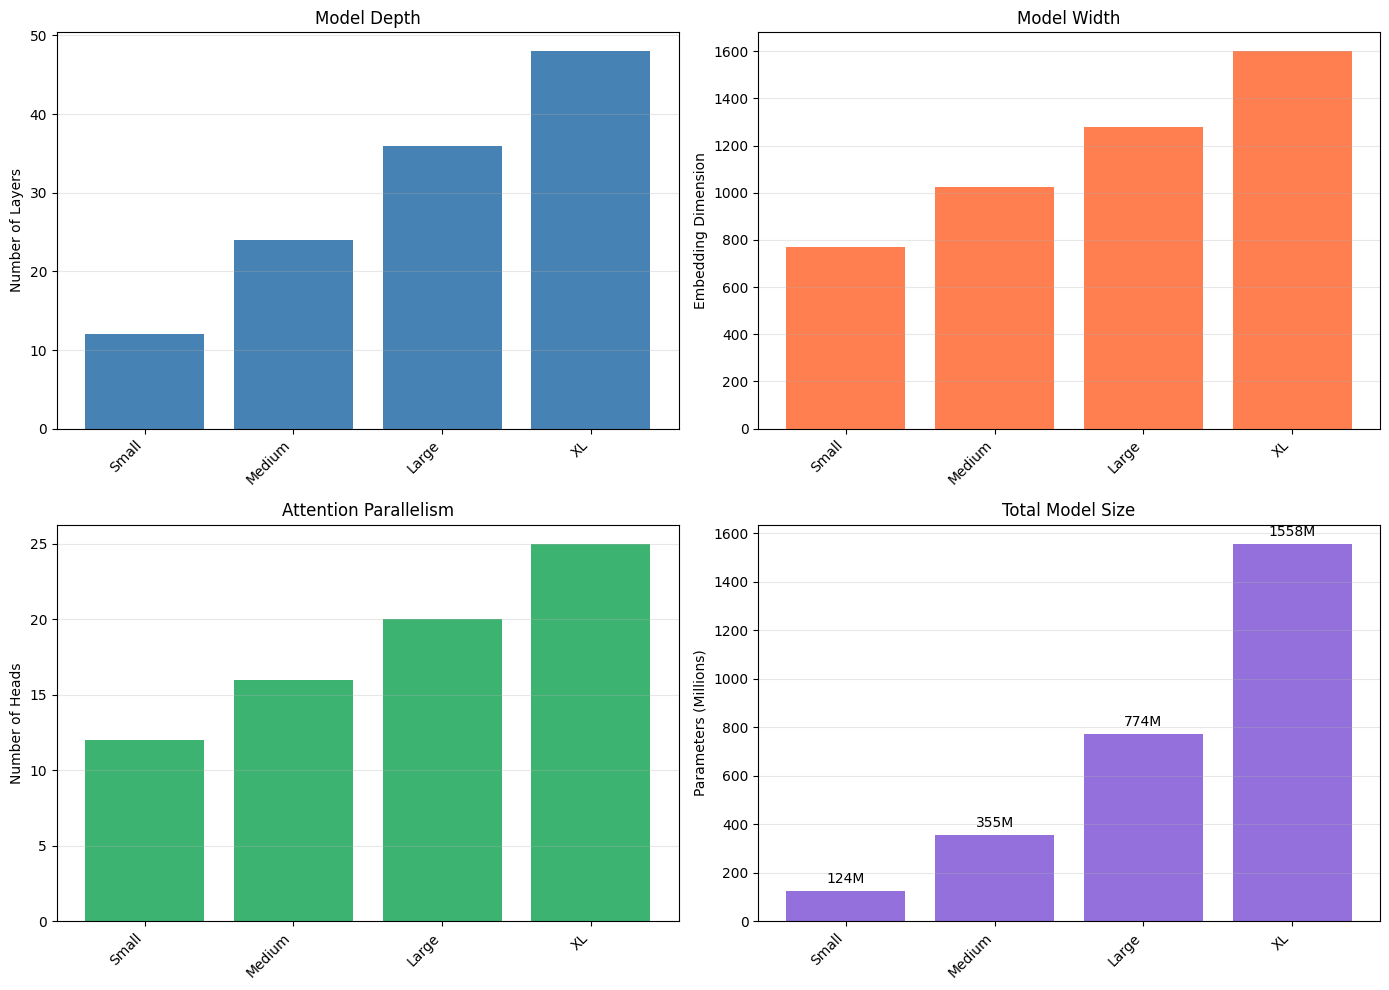


Model size scales with depth (layers), width (embd), and heads!


In [15]:
# Create all model sizes and count parameters
model_stats = {}
for name, config in configs.items():
    m = GPT2Model(config)
    model_stats[name] = {
        'layers': config.n_layer,
        'embd': config.n_embd,
        'heads': config.n_head,
        'params': m.get_num_params() / 1e6,  # In millions
    }

# Print comparison table
print('GPT-2 Model Size Comparison:')
print('=' * 80)
print(f'{"Model":15s} {"Layers":>8s} {"Emb Dim":>10s} {"Heads":>8s} {"Parameters":>15s}')
print('=' * 80)
for name, stats in model_stats.items():
    print(f'{name:15s} {stats["layers"]:>8d} {stats["embd"]:>10d} {stats["heads"]:>8d} {stats["params"]:>12.1f}M')

# Visualize scaling
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

model_names = list(model_stats.keys())
layers = [model_stats[n]['layers'] for n in model_names]
embds = [model_stats[n]['embd'] for n in model_names]
heads = [model_stats[n]['heads'] for n in model_names]
params = [model_stats[n]['params'] for n in model_names]

# Plot 1: Layers
axes[0, 0].bar(range(len(model_names)), layers, color='steelblue')
axes[0, 0].set_xticks(range(len(model_names)))
axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 0].set_ylabel('Number of Layers')
axes[0, 0].set_title('Model Depth')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Embedding dimension
axes[0, 1].bar(range(len(model_names)), embds, color='coral')
axes[0, 1].set_xticks(range(len(model_names)))
axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 1].set_ylabel('Embedding Dimension')
axes[0, 1].set_title('Model Width')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Attention heads
axes[1, 0].bar(range(len(model_names)), heads, color='mediumseagreen')
axes[1, 0].set_xticks(range(len(model_names)))
axes[1, 0].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 0].set_ylabel('Number of Heads')
axes[1, 0].set_title('Attention Parallelism')
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Total parameters
axes[1, 1].bar(range(len(model_names)), params, color='mediumpurple')
axes[1, 1].set_xticks(range(len(model_names)))
axes[1, 1].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 1].set_ylabel('Parameters (Millions)')
axes[1, 1].set_title('Total Model Size')
axes[1, 1].grid(axis='y', alpha=0.3)

for i, v in enumerate(params):
    axes[1, 1].text(i, v + 20, f'{v:.0f}M', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print('\nModel size scales with depth (layers), width (embd), and heads!')

## Verify Weight Tying

Weight Tying Verification:
lm_head.weight is wte.weight: True

Token embeddings shape: torch.Size([50257, 768])
LM head weight shape: torch.Size([50257, 768])

Memory saved by weight tying: 147.24 MB
Parameters saved: 38,597,376


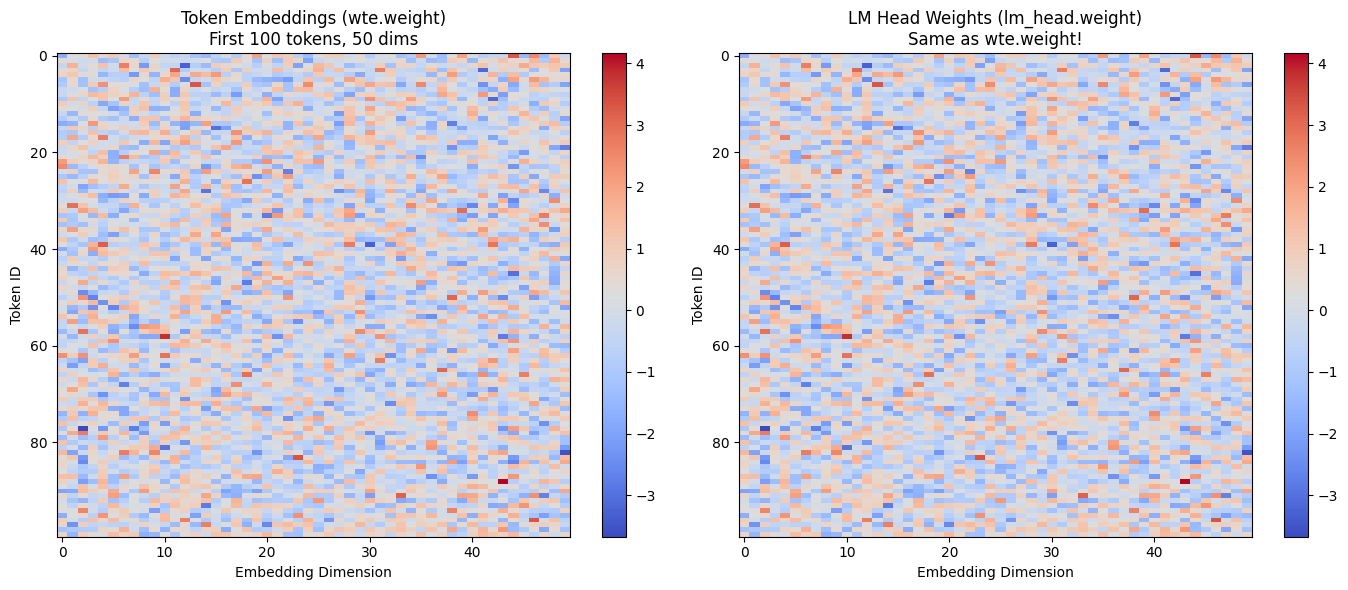


Weights are identical: True


In [6]:
# Verify weight tying between embeddings and LM head
print('Weight Tying Verification:')
print('=' * 60)

# Check if they're the same object
same_object = model.lm_head.weight is model.wte.weight
print(f'lm_head.weight is wte.weight: {same_object}')

# Check shapes
print(f'\nToken embeddings shape: {model.wte.weight.shape}')
print(f'LM head weight shape: {model.lm_head.weight.shape}')

# Calculate memory saved
num_params = model.wte.weight.numel()
param_size_mb = num_params * 4 / (1024 * 1024)  # 4 bytes per float32
print(f'\nMemory saved by weight tying: {param_size_mb:.2f} MB')
print(f'Parameters saved: {num_params:,}')

# Visualize the shared weights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot token embedding weights
wte_sample = model.wte.weight[:100, :50].detach().numpy()
im1 = ax1.imshow(wte_sample, cmap='coolwarm', aspect='auto')
ax1.set_xlabel('Embedding Dimension')
ax1.set_ylabel('Token ID')
ax1.set_title('Token Embeddings (wte.weight)\nFirst 100 tokens, 50 dims')
plt.colorbar(im1, ax=ax1)

# Plot LM head weights (same as token embeddings)
lm_head_sample = model.lm_head.weight[:100, :50].detach().numpy()
im2 = ax2.imshow(lm_head_sample, cmap='coolwarm', aspect='auto')
ax2.set_xlabel('Embedding Dimension')
ax2.set_ylabel('Token ID')
ax2.set_title('LM Head Weights (lm_head.weight)\nSame as wte.weight!')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Verify they're truly identical
print(f'\nWeights are identical: {torch.equal(model.wte.weight, model.lm_head.weight)}')

## Analyze Output Logits Distribution

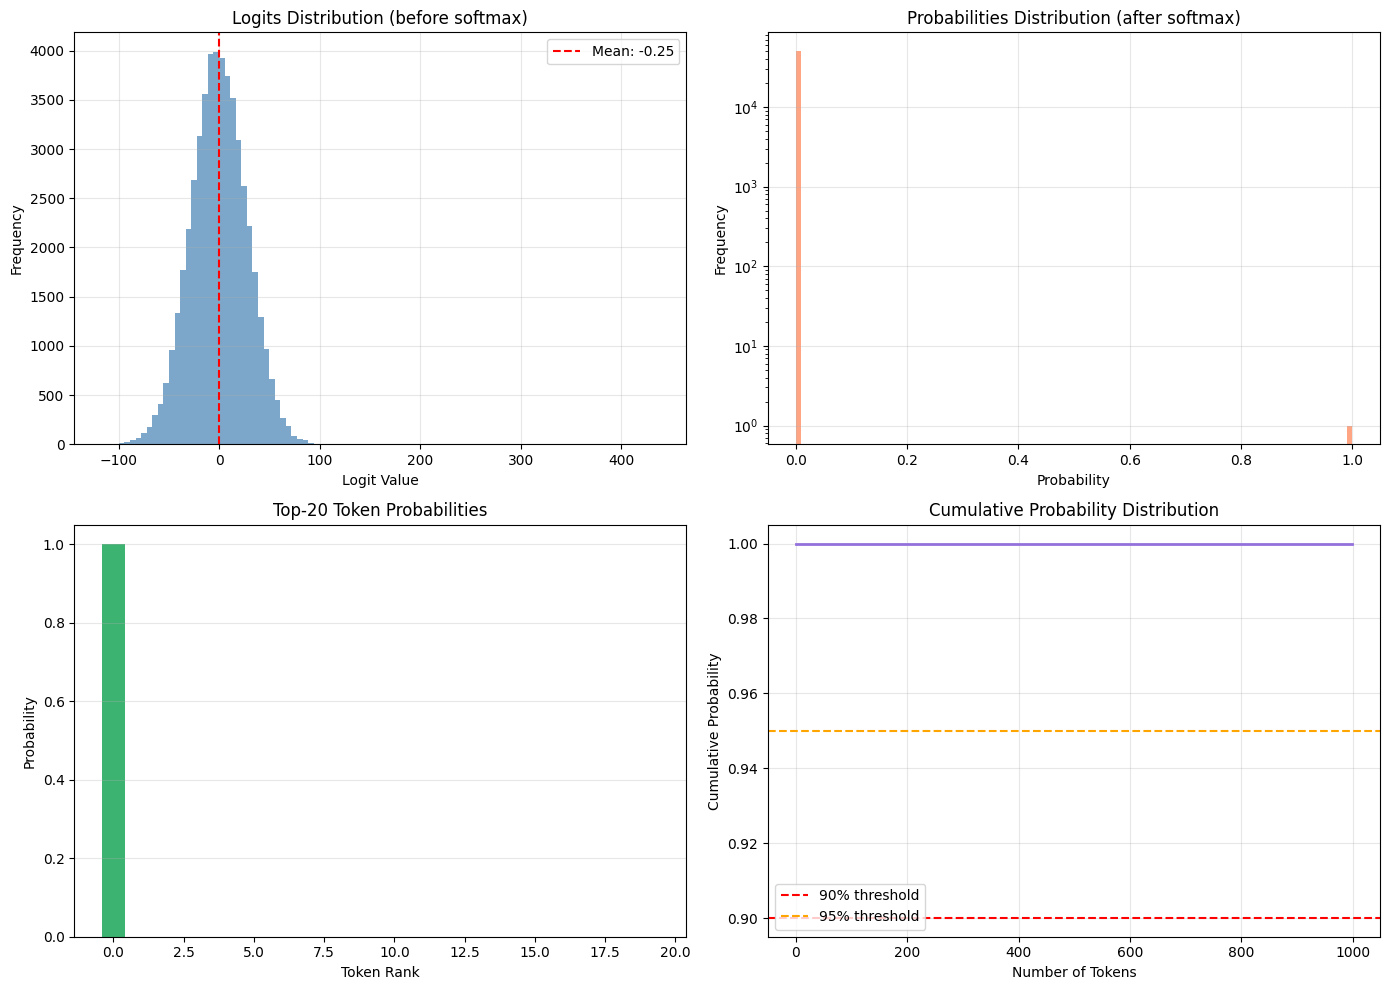

Tokens needed for 90% probability: 1
Tokens needed for 95% probability: 1
Total vocabulary size: 50,257


In [7]:
# Get predictions for a sample input
model.eval()
sample_input = torch.randint(0, small_config.vocab_size, (1, 10))

with torch.no_grad():
    logits = model(sample_input)

# Get probabilities
probs = torch.softmax(logits, dim=-1)

# Analyze first position
first_pos_logits = logits[0, 0].numpy()
first_pos_probs = probs[0, 0].numpy()

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Logits distribution
axes[0, 0].hist(first_pos_logits, bins=100, color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Logit Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Logits Distribution (before softmax)')
axes[0, 0].axvline(first_pos_logits.mean(), color='red', linestyle='--', label=f'Mean: {first_pos_logits.mean():.2f}')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Probabilities distribution
axes[0, 1].hist(first_pos_probs, bins=100, color='coral', alpha=0.7)
axes[0, 1].set_xlabel('Probability')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Probabilities Distribution (after softmax)')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(alpha=0.3)

# Top-k probabilities
top_k = 20
top_probs, top_indices = torch.topk(probs[0, 0], top_k)
axes[1, 0].bar(range(top_k), top_probs.numpy(), color='mediumseagreen')
axes[1, 0].set_xlabel('Token Rank')
axes[1, 0].set_ylabel('Probability')
axes[1, 0].set_title(f'Top-{top_k} Token Probabilities')
axes[1, 0].grid(axis='y', alpha=0.3)

# Cumulative probability
sorted_probs, _ = torch.sort(probs[0, 0], descending=True)
cumsum = torch.cumsum(sorted_probs, dim=0)
axes[1, 1].plot(cumsum[:1000].numpy(), color='mediumpurple', linewidth=2)
axes[1, 1].axhline(0.9, color='red', linestyle='--', label='90% threshold')
axes[1, 1].axhline(0.95, color='orange', linestyle='--', label='95% threshold')
axes[1, 1].set_xlabel('Number of Tokens')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].set_title('Cumulative Probability Distribution')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find how many tokens needed for 90% and 95%
tokens_90 = (cumsum >= 0.9).nonzero()[0].item() + 1
tokens_95 = (cumsum >= 0.95).nonzero()[0].item() + 1
print(f'Tokens needed for 90% probability: {tokens_90}')
print(f'Tokens needed for 95% probability: {tokens_95}')
print(f'Total vocabulary size: {small_config.vocab_size:,}')

## Trace Activations Through the Model

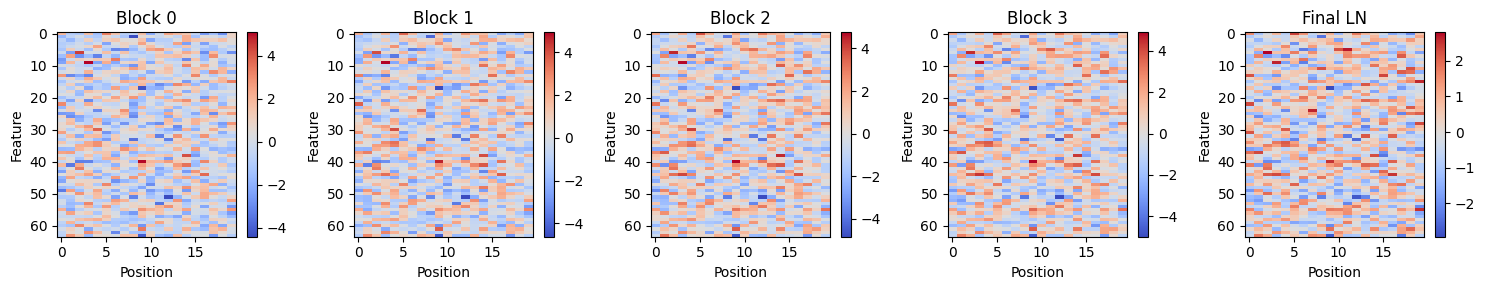

Each layer transforms the representation!
Early layers learn basic patterns, later layers learn complex semantics.


In [8]:
# Create a tiny model for visualization
tiny_config = GPT2Config(n_embd=64, n_layer=4, n_head=4, n_positions=128)
tiny_model = GPT2Model(tiny_config)
tiny_model.eval()

# Forward pass with hooks to capture intermediate activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        if isinstance(output, torch.Tensor):
            activations[name] = output.detach()
    return hook

# Register hooks
for i, block in enumerate(tiny_model.h):
    block.register_forward_hook(get_activation(f'block_{i}'))

tiny_model.ln_f.register_forward_hook(get_activation('final_ln'))

# Forward pass
sample = torch.randint(0, tiny_config.vocab_size, (1, 20))
with torch.no_grad():
    output = tiny_model(sample)

# Visualize activations at each layer
fig, axes = plt.subplots(1, len(tiny_model.h) + 1, figsize=(15, 3))

for i in range(len(tiny_model.h)):
    act = activations[f'block_{i}'][0].numpy()  # (seq_len, n_embd)
    im = axes[i].imshow(act.T, cmap='coolwarm', aspect='auto')
    axes[i].set_xlabel('Position')
    axes[i].set_ylabel('Feature')
    axes[i].set_title(f'Block {i}')
    plt.colorbar(im, ax=axes[i])

# Final layer norm
final_act = activations['final_ln'][0].numpy()
im = axes[-1].imshow(final_act.T, cmap='coolwarm', aspect='auto')
axes[-1].set_xlabel('Position')
axes[-1].set_ylabel('Feature')
axes[-1].set_title('Final LN')
plt.colorbar(im, ax=axes[-1])

plt.tight_layout()
plt.show()

print('Each layer transforms the representation!')
print('Early layers learn basic patterns, later layers learn complex semantics.')

## Model Summary

In [9]:
def print_model_summary(model, config):
    """Print a comprehensive model summary."""
    print('GPT-2 Model Summary')
    print('=' * 80)
    print(f'Configuration:')
    print(f'  Layers: {config.n_layer}')
    print(f'  Embedding dimension: {config.n_embd}')
    print(f'  Attention heads: {config.n_head}')
    print(f'  Head dimension: {config.n_embd // config.n_head}')
    print(f'  FFN inner dimension: {config.n_inner}')
    print(f'  Vocabulary size: {config.vocab_size:,}')
    print(f'  Context length: {config.n_positions}')
    print(f'\nDropout rates:')
    print(f'  Embedding dropout: {config.embd_pdrop}')
    print(f'  Attention dropout: {config.attn_pdrop}')
    print(f'  Residual dropout: {config.resid_pdrop}')
    print(f'\nParameter count:')
    breakdown = model.get_num_params_by_component()
    for component, count in breakdown.items():
        if component == 'total':
            print('  ' + '-' * 40)
        pct = (count / breakdown['total'] * 100) if breakdown['total'] > 0 else 0
        print(f'  {component:25s}: {count:>12,} ({pct:>5.1f}%)')
    print('=' * 80)

# Print summary for GPT-2 small
print_model_summary(model, small_config)

print('\n✅ Complete GPT-2 model assembled!')
print('\nNext step: Problem 11 - Weight Initialization')

GPT-2 Model Summary
Configuration:
  Layers: 12
  Embedding dimension: 768
  Attention heads: 12
  Head dimension: 64
  FFN inner dimension: 3072
  Vocabulary size: 50,257
  Context length: 1024

Dropout rates:
  Embedding dropout: 0.1
  Attention dropout: 0.1
  Residual dropout: 0.1

Parameter count:
  embeddings               :   39,383,808 ( 31.6%)
  transformer_blocks       :   85,054,464 ( 68.3%)
  final_ln                 :        1,536 (  0.0%)
  lm_head                  :            0 (  0.0%)
  ----------------------------------------
  total                    :  124,439,808 (100.0%)

✅ Complete GPT-2 model assembled!

Next step: Problem 11 - Weight Initialization


## Verify Your Implementation

In [10]:
# Quick verification
test_config = GPT2Config(n_embd=256, n_layer=2, n_head=4)
test_model = GPT2Model(test_config)

# Test forward pass
test_input = torch.randint(0, test_config.vocab_size, (2, 10))
test_output = test_model(test_input)

print('✓ GPT2Model created successfully')
print('✓ All components initialized')
print('✓ Forward pass works')
print('✓ Weight tying implemented')
print(f'✓ Output shape correct: {test_output.shape}')
print('\n✅ Full GPT-2 model assembly complete!')
print('\nRun "uv run pytest test_gpt2.py -v" for complete validation.')

✓ GPT2Model created successfully
✓ All components initialized
✓ Forward pass works
✓ Weight tying implemented
✓ Output shape correct: torch.Size([2, 10, 50257])

✅ Full GPT-2 model assembly complete!

Run "uv run pytest test_gpt2.py -v" for complete validation.
